In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp
import optax
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

# Enable 64-bit precision for better numerical stability
# jax.config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Define Variables and Constraints

In [15]:
from calibrated_response.models.variable import (Variable, BinaryVariable, ContinuousVariable)
from calibrated_response.maxent.constraints import (Constraint, 
    ConstraintSet, ProbabilityConstraint, MeanConstraint, QuantileConstraint, ConditionalQuantileConstraint, to_bins
)

# Define three variables: binary, continuous, binary
variables = [
    BinaryVariable(
        name="market_crash",
        description="Whether a major market crash occurs",
        importance=0.8,
        prior_probability=0.15,
        yes_label="crash",
        no_label="no crash",
        is_target=False
    ),
    ContinuousVariable(
        name="stock_return",
        description="Annual stock market return percentage",
        importance=0.9,
        lower_bound=-50,
        upper_bound=100,
        unit="percent",
        is_target=False
    ),
    BinaryVariable(
        name="recession",
        description="Whether the economy enters a recession",
        importance=0.7,
        prior_probability=0.20,
        yes_label="recession",
        no_label="no recession",
        is_target=False
    ),
]

print(f"Variables: {[v.name for v in variables]}")
for v in variables:
    print(f"  - {v.name} ({v.type}): {v.description}")

Variables: ['market_crash', 'stock_return', 'recession']
  - market_crash (binary): Whether a major market crash occurs
  - stock_return (continuous): Annual stock market return percentage
  - recession (binary): Whether the economy enters a recession


In [12]:
# Define constraints with variable indices
# constraint_var_ind[i] tells us which variable constraint i applies to

constraints = [
    # Constraints on stock_return (variable index 1)
    MeanConstraint(
        id="mean_return",
        target_variable=variables[1],
        mean=8.0,
        confidence=0.85,
        source_query_id="q1"
    ),
    ProbabilityConstraint(
        id="positive_return",
        target_variable=variables[1],
        lower_bound=0,
        upper_bound=100,
        probability=0.70,
        confidence=0.9,
        source_query_id="q2"
    ),
    QuantileConstraint(
        id="median_return",
        target_variable=variables[1],
        quantile=0.5,
        value=10.0,
        confidence=0.8,
        source_query_id="q3"
    ),
    # Constraint on market_crash (variable index 0)
    QuantileConstraint(
        id='crash_likelihood',
        target_variable=variables[0],
        quantile=0.85,
        value=0,
        confidence=0.8,
        source_query_id="q4"
    ),
    # Constraint on recession (variable index 2)
    QuantileConstraint(
        id='recession_likelihood',
        target_variable=variables[2],
        quantile=0.75,
        value=0,
        confidence=0.75,
        source_query_id="q5"
    ), 
    ConditionalQuantileConstraint(
        id='conditional_recession_likelihood',
        target_variable=variables[1],
        quantile=0.9,
        value=0,
        condition_variables=[variables[0]],
        condition_values=[0.0],
        confidence=0.8,
        source_query_id="q6"
    )
]

print(f"Created {len(constraints)} constraints:")
for i, c in enumerate(constraints):
    print(f"  {i+1}. {c.id} on '{c.target_variable.name}': target={c.target_value()}, confidence={c.confidence}")

Created 6 constraints:
  1. mean_return on 'stock_return': target=8.0, confidence=0.85
  2. positive_return on 'stock_return': target=0.7, confidence=0.9
  3. median_return on 'stock_return': target=0.5, confidence=0.8
  4. crash_likelihood on 'market_crash': target=0.85, confidence=0.8
  5. recession_likelihood on 'recession': target=0.75, confidence=0.75
  6. conditional_recession_likelihood on 'stock_return': target=0.9, confidence=0.8


## 2. Discretization and Initial Distribution

In [9]:
def discretize_variables(variables: list[Variable], max_bins: int = 5):
    """Convert variables to discrete bin edges and uniform marginals."""
    bin_edges_list = [to_bins(var, max_bins=max_bins) for var in variables]
    
    # Create uniform marginals for each variable
    marginals = []
    for bins in bin_edges_list:
        n_bins = len(bins) - 1
        marginals.append(np.ones(n_bins) / n_bins)
    return bin_edges_list, marginals


def create_joint_distribution(marginals: list[np.ndarray]) -> np.ndarray:
    """Create joint distribution assuming independence (outer product of marginals)."""
    p = marginals[0]
    for i in range(1, len(marginals)):
        p = p.reshape(p.shape + (1,)) * marginals[i].reshape((1,) * i + (-1,))
    return p

# Discretize
bin_edges_list, marginals = discretize_variables(variables, max_bins=25)
p0 = create_joint_distribution(marginals)

print("Bin edges per variable:")
for v, bins in zip(variables, bin_edges_list):
    print(f"  {v.name}: {len(bins)-1} bins, edges = {bins[:3]}...{bins[-3:]}")

print(f"\nJoint distribution shape: {p0.shape}")
print(f"Total probability mass: {p0.sum():.6f}")

Bin edges per variable:
  market_crash: 2 bins, edges = [-1  0  1]...[-1  0  1]
  stock_return: 25 bins, edges = [-50. -44. -38.]...[ 88.  94. 100.]
  recession: 2 bins, edges = [-1  0  1]...[-1  0  1]

Joint distribution shape: (2, 25, 2)
Total probability mass: 1.000000


## 3. JAX-Based Objective Function

The objective function minimizes:
$$\mathcal{L}(p) = -H(p) + \lambda \sum_i w_i (f_i(p) - b_i)^2$$

where:
- $H(p) = -\sum_x p(x) \log p(x)$ is the entropy
- $f_i(p)$ evaluates constraint $i$ on the appropriate marginal
- $b_i$ is the target value for constraint $i$
- $w_i$ is the confidence weight
- $\lambda$ is the constraint penalty weight

In [ ]:
# Helper functions for JAX

from typing import List


def compute_marginal_jax(p: jnp.ndarray, var_idx: int, n_vars: int) -> jnp.ndarray:
    """Compute marginal distribution for a single variable using einsum.
    
    Args:
        p: Joint distribution array
        var_idx: Index of variable to marginalize to
        n_vars: Total number of variables
    
    Returns:
        Marginal distribution for the specified variable
    """
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    input_dims = ''.join(alphabet[i] for i in range(n_vars))
    output_dim = alphabet[var_idx]
    return jnp.einsum(f'{input_dims}->{output_dim}', p)

def evaluate_mean_constraint_jax(marginal: jnp.ndarray, bin_edges: jnp.ndarray) -> jnp.ndarray:
    """Evaluate E[X] for a marginal distribution."""
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return jnp.sum(marginal * bin_centers)

def evaluate_probability_constraint_jax(
    marginal: jnp.ndarray, 
    bin_edges: jnp.ndarray,
    lower_bound: float,
    upper_bound: float
) -> jnp.ndarray:
    """Evaluate P(lower <= X <= upper) for a marginal distribution."""
    # Compute overlap of each bin with [lower, upper]
    bin_lefts = bin_edges[:-1]
    bin_rights = bin_edges[1:]
    bin_widths = bin_rights - bin_lefts
    
    overlap_lefts = jnp.maximum(bin_lefts, lower_bound)
    overlap_rights = jnp.minimum(bin_rights, upper_bound)
    overlap_widths = jnp.maximum(0, overlap_rights - overlap_lefts)
    
    # Fraction of each bin that overlaps
    overlap_fracs = jnp.where(bin_widths > 0, overlap_widths / bin_widths, 0.0)
    
    return jnp.sum(marginal * overlap_fracs)


def evaluate_quantile_constraint_jax(
    marginal: jnp.ndarray,
    bin_edges: jnp.ndarray,
    quantile_value: float  # the x value where P(X <= x) = q
) -> jnp.ndarray:
    """Evaluate P(X <= value) for a marginal distribution.
    
    Returns the CDF at the quantile value, which should equal the target quantile.
    """
    bin_lefts = bin_edges[:-1]
    bin_rights = bin_edges[1:]
    bin_widths = bin_rights - bin_lefts
    
    # For each bin, compute how much of it is <= quantile_value
    # If quantile_value >= bin_right: full bin contributes
    # If quantile_value <= bin_left: nothing contributes  
    # Otherwise: linear interpolation
    frac_below = jnp.clip((quantile_value - bin_lefts) / jnp.maximum(bin_widths, 1e-10), 0.0, 1.0)
    
    return jnp.sum(marginal * frac_below)

def evaluate_precondition_quantile_constraint_jax(p: jnp.ndarray, precondition_mask: jnp.ndarray, maginal_index: int, 
                                                  bin_edges: jnp.ndarray, quantile_value: float) -> jnp.ndarray:
    """Evaluate a quantile constraint under a precondition mask."""
    # Apply precondition mask to joint distribution
    p_masked = p * precondition_mask
    p_masked /= jnp.sum(p_masked)  # Renormalize
    # Compute marginal for the specified variable
    marginal = compute_marginal_jax(p_masked, maginal_index, len(p.shape))
    # Evaluate quantile constraint on the marginal
    bin_lefts = bin_edges[:-1]
    bin_rights = bin_edges[1:]
    bin_widths = bin_rights - bin_lefts
    frac_below = jnp.clip((quantile_value - bin_lefts) / jnp.maximum(bin_widths, 1e-10), 0.0, 1.0)
    return jnp.sum(marginal * frac_below)

def evaluate_precondition_mean_constraint_jax(p: jnp.ndarray, precondition_mask: jnp.ndarray, maginal_index: int, 
                                                  bin_edges: jnp.ndarray, quantile_value: float) -> jnp.ndarray:
    """Evaluate a quantile constraint under a precondition mask."""
    # Apply precondition mask to joint distribution
    p_masked = p * precondition_mask
    p_masked /= jnp.sum(p_masked)  # Renormalize
    # Compute marginal for the specified variable
    marginal = compute_marginal_jax(p_masked, maginal_index, len(p.shape))
    # Evaluate quantile constraint on the marginal
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return jnp.sum(marginal * bin_centers)

def gen_quantile_precondition_mask(bin_edges: List[jnp.ndarray], condition_values: np.ndarray):
    m = []
    for edges, q in zip(bin_edges, condition_values):
        bin_lefts = edges[:-1]
        bin_rights = edges[1:]
        bin_widths = bin_rights - bin_lefts
        
        frac_below = jnp.clip((q - bin_lefts) / jnp.maximum(bin_widths, 1e-10), 0.0, 1.0)
        m.append(frac_below)
    # Create joint mask via outer product
    precondition_mask = m[0]
    for i in range(1, len(m)):
        precondition_mask = precondition_mask.reshape(precondition_mask.shape + (1,)) * m[i].reshape((1,) * i + (-1,))
    return precondition_mask


In [16]:
def create_objective_fn(
    variables: list[Variable],
    constraints: list[Constraint],
    bin_edges_list: list[np.ndarray],
    n_vars: int,
    constraint_weight: float = 3.0,
    regularization: float = 0.01
):
    """Create a JAX-compatible objective function for the MaxEnt problem.
    
    The function operates on log-probabilities for numerical stability.
    """
    # Convert bin edges to JAX arrays

    bin_edges_jax = [jnp.array(b) for b in bin_edges_list]
    
    # Extract constraint parameters
    constraint_params = []
    for c in constraints:
        if hasattr(c, 'mean'):
            constraint_params.append(('mean', c.mean, c.confidence))
        elif hasattr(c, 'probability'):
            constraint_params.append(('probability', (c.lower_bound, c.upper_bound, c.probability), c.confidence))
        elif hasattr(c, 'quantile'):
            constraint_params.append(('quantile', (c.value, c.quantile), c.confidence))
        elif hasattr(c, 'conditional_quantile'):
            var_condition_values = np.full((n_vars,), -np.inf)
            for cv, var in zip(c.condition_values, c.condition_variables):
                var_idx = variables.index(var)
                var_condition_values[var_idx] = max(cv, var_condition_values[var_idx])
            precondition_mask = gen_quantile_precondition_mask(bin_edges_jax, var_condition_values)
            constraint_params.append(('conditional_quantile', (c.value, c.quantile, precondition_mask), c.confidence))
    
    def objective(log_p_flat: jnp.ndarray, shape: tuple) -> jnp.ndarray:
        """Objective function: -entropy + constraint penalties.
        
        Args:
            log_p_flat: Flattened log-probabilities
            shape: Original shape of the joint distribution
        
        Returns:
            Scalar objective value
        """
        # Reshape and normalize
        log_p = log_p_flat.reshape(shape)
        log_p_normalized = log_p - logsumexp(log_p)  # log-softmax for normalization
        p = jnp.exp(log_p_normalized)
        
        # Entropy: H(p) = -sum(p * log(p))
        # Using log_p_normalized to avoid numerical issues
        entropy = -jnp.sum(p * log_p_normalized)
        neg_entropy = -entropy
        
        # Constraint violations
        penalty = 0.0
        constraint_var_ind = [variables.index(c.target_variable) for c in constraints]
        for var_idx, (ctype, params, confidence) in zip(constraint_var_ind, constraint_params):
            marginal = compute_marginal_jax(p, var_idx, n_vars)
            bins = bin_edges_jax[var_idx]
            
            if ctype == 'mean':
                actual = evaluate_mean_constraint_jax(marginal, bins)
                target = params
            elif ctype == 'probability':
                lower, upper, prob = params
                actual = evaluate_probability_constraint_jax(marginal, bins, lower, upper)
                target = prob
            elif ctype == 'quantile':
                value, quantile = params
                actual = evaluate_quantile_constraint_jax(marginal, bins, value)
                target = quantile
            elif ctype == 'conditional_quantile':
                value, quantile, precondition_mask = params
                # Generate precondition mask
                actual = evaluate_precondition_quantile_constraint_jax(p, precondition_mask, var_idx, bins, value)
                target = quantile
            else:
                raise ValueError(f"Unknown constraint type: {ctype}")
            
            violation = (actual - target) ** 2
            penalty += confidence * violation
        
        # L2 regularization on log-probabilities
        reg = regularization * jnp.sum(log_p_flat ** 2)
        
        return neg_entropy + constraint_weight * penalty + reg
    
    return objective

# Create objective function
objective_fn = create_objective_fn(
    variables=variables,
    constraints=constraints,
    bin_edges_list=bin_edges_list,
    n_vars=len(variables),
    constraint_weight=3.0,
    regularization=0.001
)

# Test the objective function
log_p0_flat = jnp.log(p0.flatten() + 1e-12)
initial_loss = objective_fn(log_p0_flat, p0.shape)
print(f"Initial objective value: {initial_loss:.4f}")

Initial objective value: 735.6978


## 4. JAX-Based Optimization with Automatic Gradients

In [17]:
from jaxopt import LBFGS

def solve_maxent_lbfgs(
    objective_fn,
    p0: np.ndarray,
    maxiter: int = 500,
    tol: float = 1e-6,
    verbose: bool = True
):
    """Solve the MaxEnt problem using JAX and jaxopt L-BFGS.
    
    Args:
        objective_fn: JAX-compatible objective function
        p0: Initial distribution
        maxiter: Maximum number of iterations
        tol: Convergence tolerance
        verbose: Whether to print progress
    
    Returns:
        Tuple of (optimized_distribution, info_dict)
    """
    shape = p0.shape
    log_p0 = jnp.log(p0.flatten() + 1e-12)
    
    # Create objective that takes shape as a fixed argument
    def obj_with_shape(log_p_flat):
        return objective_fn(log_p_flat, shape)
    
    # Create L-BFGS solver
    solver = LBFGS(
        fun=obj_with_shape,
        maxiter=maxiter,
        tol=tol,
        verbose=verbose
    )
    
    # Run optimization
    result = solver.run(log_p0)
    log_p_optimal = result.params
    
    # Extract final distribution
    log_p_normalized = log_p_optimal.reshape(shape) - logsumexp(log_p_optimal)
    p_final = np.array(jnp.exp(log_p_normalized))
    
    # Compute final entropy
    entropy = -np.sum(p_final * np.log(p_final + 1e-12))
    
    # Get final loss
    final_loss = float(obj_with_shape(log_p_optimal))
    
    info = {
        'n_iterations': int(result.state.iter_num),
        'final_loss': final_loss,
        'entropy': entropy,
        'converged': result.state.error < tol,
        'error': float(result.state.error),
        'state': result.state
    }
    
    if verbose:
        print(f"\nL-BFGS completed:")
        print(f"  Iterations: {info['n_iterations']}")
        print(f"  Final error: {info['error']:.2e}")
        print(f"  Converged: {info['converged']}")
    
    return p_final, info


# Solve using L-BFGS!
p_optimal, info = solve_maxent_lbfgs(
    objective_fn,
    p0,
    maxiter=1000,
    tol=1e-5,
    verbose=True
)

print(f"\nOptimization complete!")
print(f"  Final loss: {info['final_loss']:.6f}")
print(f"  Entropy: {info['entropy']:.4f}")
print(f"  Converged: {info['converged']}")

INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 209.96627807617188 Objective Value:273.7611389160156  Stepsize:0.018421588465571404  Number Linesearch Iterations:5 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 169.96060180664062 Objective Value:181.31436157226562  Stepsize:0.22105905413627625  Number Linesearch Iterations:4 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 110.16349029541016 Objective Value:74.41128540039062  Stepsize:0.3315885663032532  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 48.07281494140625 Objective Value:12.61593246459961  Stepsize:0.49738284945487976  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 8.181476593017578 Objective Value:-1.038820505142212  Stepsize:0.7460742592811584  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.4355580806732178 Objective Value:-1

## 5. Analyze Results

In [ ]:
def extract_marginal(p: np.ndarray, var_idx: int) -> np.ndarray:
    """Extract marginal distribution for a variable."""
    n_vars = len(p.shape)
    axes_to_sum = tuple(i for i in range(n_vars) if i != var_idx)
    return p.sum(axis=axes_to_sum)


# Check constraint satisfaction
print("Constraint Satisfaction:")
print("=" * 60)
constraint_var_ind = [variables.index(c.target_variable) for c in constraints]
for i, (c, var_idx) in enumerate(zip(constraints, constraint_var_ind)):
    marginal = extract_marginal(p_optimal, var_idx)
    bins = bin_edges_list[var_idx]
    
    # actual = c.evaluate(marginal, bins)
    target = c.target_value()
    error = abs(actual - target)
    
    status = "✓" if error < 0.05 else "✗"
    print(f"{status} {c.id:20s} on {variables[var_idx].name:15s}: "
          f"target={target:.3f}, actual={actual:.3f}, error={error:.4f}")

Constraint Satisfaction:
✓ mean_return          on stock_return   : target=8.000, actual=8.002, error=0.0016
✗ positive_return      on stock_return   : target=0.700, actual=0.480, error=0.2202


AttributeError: 'QuantileConstraint' object has no attribute 'evaluate'

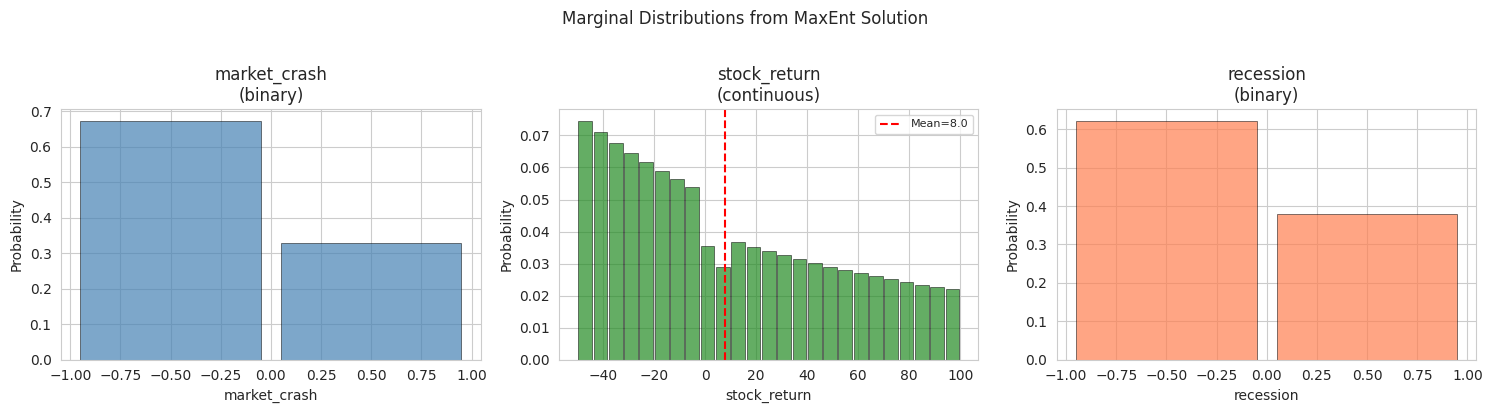

In [19]:
# Plot marginal distributions
fig, axes = plt.subplots(1, len(variables), figsize=(15, 4))

colors = ['steelblue', 'forestgreen', 'coral']

for i, (var, bins, color) in enumerate(zip(variables, bin_edges_list, colors)):
    marginal = extract_marginal(p_optimal, i)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]
    
    axes[i].bar(bin_centers, marginal, width=bin_width * 0.9, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[i].set_xlabel(var.name)
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f'{var.name}\n({var.type})')
    
    # Add mean line for continuous variables
    if var.type == 'continuous':
        mean = np.sum(marginal * bin_centers)
        axes[i].axvline(mean, color='red', linestyle='--', label=f'Mean={mean:.1f}')
        axes[i].legend(fontsize=8)

plt.suptitle('Marginal Distributions from MaxEnt Solution', y=1.02)
plt.tight_layout()
plt.show()

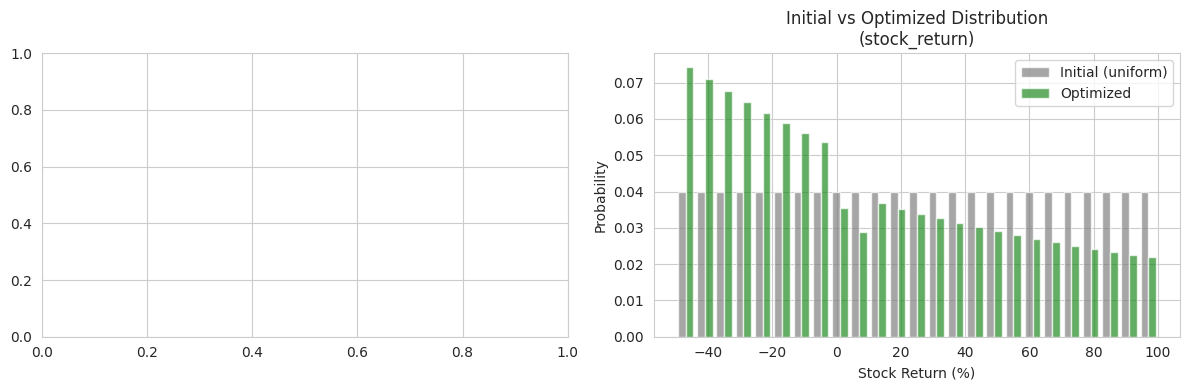

In [20]:
# Plot optimization convergence
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
# Compare initial vs final marginals for stock_return
var_idx = 1  # stock_return
bins = bin_edges_list[var_idx]
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_marginal = extract_marginal(p0, var_idx)
final_marginal = extract_marginal(p_optimal, var_idx)

width = (bins[1] - bins[0]) * 0.4
axes[1].bar(bin_centers - width/2, initial_marginal, width=width, alpha=0.7, label='Initial (uniform)', color='gray')
axes[1].bar(bin_centers + width/2, final_marginal, width=width, alpha=0.7, label='Optimized', color='forestgreen')
axes[1].set_xlabel('Stock Return (%)')
axes[1].set_ylabel('Probability')
axes[1].set_title('Initial vs Optimized Distribution\n(stock_return)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Examine Joint Distribution Structure

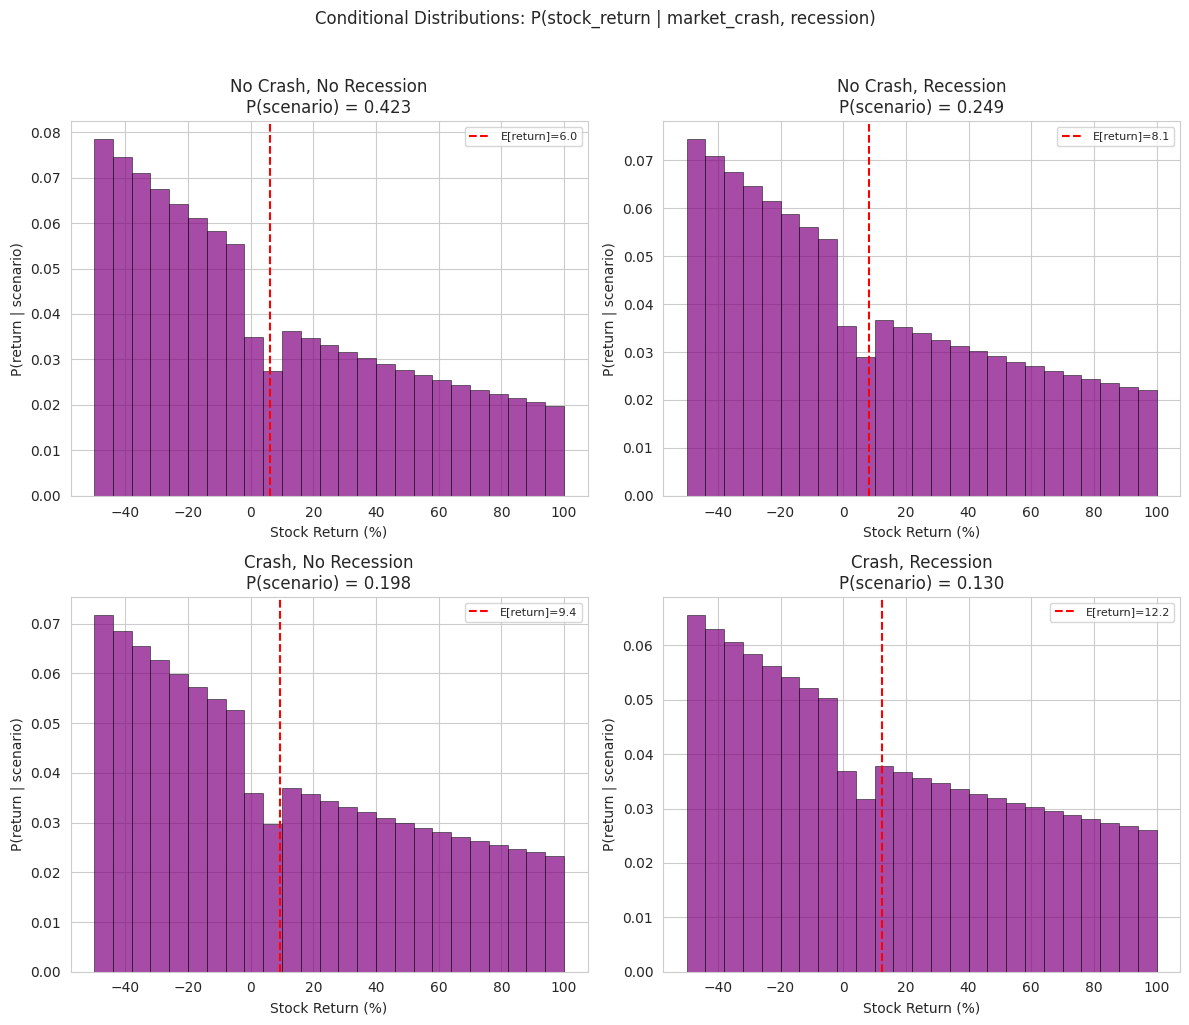

In [21]:
# For 3 variables with binary + continuous + binary, we can visualize slices

# Slice: P(stock_return | market_crash, recession)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

stock_bins = bin_edges_list[1]
stock_centers = (stock_bins[:-1] + stock_bins[1:]) / 2

scenarios = [
    (0, 0, 'No Crash, No Recession'),
    (0, 1, 'No Crash, Recession'),
    (1, 0, 'Crash, No Recession'),
    (1, 1, 'Crash, Recession'),
]

for ax, (crash, recession, title) in zip(axes.flatten(), scenarios):
    # P(stock_return | crash, recession) = P(crash, stock_return, recession) / P(crash, recession)
    joint_slice = p_optimal[crash, :, recession]
    marginal = joint_slice.sum()
    if marginal > 1e-10:
        conditional = joint_slice / marginal
    else:
        conditional = joint_slice
    
    ax.bar(stock_centers, conditional, width=stock_bins[1]-stock_bins[0], 
           alpha=0.7, color='purple', edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Stock Return (%)')
    ax.set_ylabel('P(return | scenario)')
    ax.set_title(f'{title}\nP(scenario) = {marginal:.3f}')
    
    # Add conditional mean
    if marginal > 1e-10:
        cond_mean = np.sum(conditional * stock_centers)
        ax.axvline(cond_mean, color='red', linestyle='--', label=f'E[return]={cond_mean:.1f}')
        ax.legend(fontsize=8)

plt.suptitle('Conditional Distributions: P(stock_return | market_crash, recession)', y=1.02)
plt.tight_layout()
plt.show()

In [58]:
# Summary statistics
print("\nSummary Statistics:")
print("=" * 60)

for i, var in enumerate(variables):
    marginal = extract_marginal(p_optimal, i)
    bins = bin_edges_list[i]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    mean = np.sum(marginal * bin_centers)
    var_val = np.sum(marginal * (bin_centers - mean)**2)
    std = np.sqrt(var_val)
    
    print(f"\n{var.name} ({var.type}):")
    print(f"  Mean: {mean:.3f}")
    print(f"  Std:  {std:.3f}")
    
    if var.type == 'binary':
        print(f"  P(yes): {marginal[1]:.3f}")
        print(f"  P(no):  {marginal[0]:.3f}")


Summary Statistics:

market_crash (binary):
  Mean: -0.332
  Std:  0.374
  P(yes): 0.168
  P(no):  0.832

stock_return (continuous):
  Mean: 7.998
  Std:  35.282

recession (binary):
  Mean: -0.241
  Std:  0.438
  P(yes): 0.259
  P(no):  0.741


## 7. Reusable Solver Class

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class JAXSolverConfig:
    """Configuration for JAX-based MaxEnt solver."""
    maxiter: int = 500
    tolerance: float = 1e-5
    constraint_weight: float = 100.0
    regularization: float = 0.001
    max_bins: int = 10
    verbose: bool = False


class MultivariateMaxEntSolver:
    """JAX-based multivariate maximum entropy solver using L-BFGS."""
    
    def __init__(self, config: Optional[JAXSolverConfig] = None):
        self.config = config or JAXSolverConfig()
    
    def solve(
        self,
        variables: list[Variable],
        constraints: list,
    ) -> Tuple[np.ndarray, list[np.ndarray], dict]:
        """Solve the multivariate MaxEnt problem.
        
        Args:
            variables: List of Variable objects
            constraints: List of Constraint objects
            constraint_var_indices: Index of variable for each constraint
        
        Returns:
            Tuple of (joint_distribution, bin_edges_list, info_dict)
        """
        # Discretize
        bin_edges_list, marginals = discretize_variables(variables, self.config.max_bins)
        p0 = create_joint_distribution(marginals)
        
        # Create objective
        objective_fn = create_objective_fn(
            variables=variables,
            constraints=constraints,
            bin_edges_list=bin_edges_list,
            n_vars=len(variables),
            constraint_weight=self.config.constraint_weight,
            regularization=self.config.regularization
        )
        
        # Solve using L-BFGS
        p_optimal, info = solve_maxent_lbfgs(
            objective_fn,
            p0,
            maxiter=self.config.maxiter,
            tol=self.config.tolerance,
            verbose=self.config.verbose
        )
        
        # Add constraint satisfaction to info
        info['constraint_satisfaction'] = {}
        constraint_var_ind = [variables.index(c.target_variable) for c in constraints]
        for c, var_idx in zip(constraints, constraint_var_ind):
            actual = jax_evaluate(c, p_optimal, var_idx, bin_edges_list[var_idx], variables)
            target = c.target_value()
            info['constraint_satisfaction'][c.id] = {
                'target': target,
                'actual': actual,
                'error': abs(actual - target)
            }
        
        return p_optimal, bin_edges_list, info


# Test the class
solver = MultivariateMaxEntSolver(JAXSolverConfig(verbose=True))
p_result, bins_result, result_info = solver.solve(variables, constraints, constraint_var_ind)

print("\nConstraint satisfaction:")
for cid, stats in result_info['constraint_satisfaction'].items():
    print(f"  {cid}: target={stats['target']:.3f}, actual={stats['actual']:.3f}, error={stats['error']:.4f}")

INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 912.064453125 Objective Value:72.30792999267578  Stepsize:0.00013774687249679118  Number Linesearch Iterations:11 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 820.0230102539062 Objective Value:61.39124298095703  Stepsize:0.10578960180282593  Number Linesearch Iterations:10 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 689.962646484375 Objective Value:47.92864990234375  Stepsize:0.1586844027042389  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 525.7764282226562 Objective Value:34.229393005371094  Stepsize:0.23802660405635834  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 338.07574462890625 Objective Value:23.087186813354492  Stepsize:0.3570398986339569  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 157.03604125976562 Objective Value:16.91